## ノードの並列実行

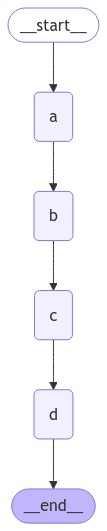

In [2]:
from IPython.display import Image, display

from typing import Any
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    # reducerがないので上書きされる
    state: str

class ReturnNodeValue:
    def __init__(self, node_secret: str):
        self._value = node_secret
    
    def __call__(self, state: State) -> Any:
        print(f"Adding {self._value} to {state['state']}")
        return {"state": [self._value]}

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("私はAです"))
builder.add_node("b", ReturnNodeValue("私はBです"))
builder.add_node("c", ReturnNodeValue("私はCです"))
builder.add_node("d", ReturnNodeValue("私はDです"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("b", "c")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
ReturnNodeValue("私はAです")({"state": []})

Adding 私はAです to []


{'state': ['私はAです']}

In [10]:
graph.invoke({"state": []})

Adding 私はAです to []
Adding 私はBです to ['私はAです']
Adding 私はCです to ['私はBです']
Adding 私はDです to ['私はCです']


{'state': ['私はDです']}

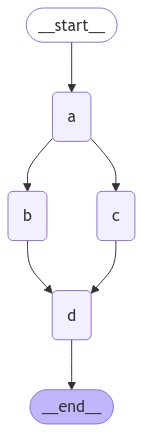

In [12]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("私はAです"))
builder.add_node("b", ReturnNodeValue("私はBです"))
builder.add_node("c", ReturnNodeValue("私はCです"))
builder.add_node("d", ReturnNodeValue("私はDです"))

builder.add_edge(START, "a")

# aからbとcに分岐
builder.add_edge("a", "b")
builder.add_edge("a", "c")

builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"state": []})
except InvalidUpdateError as e:
    print(f"An error occurred: {e}")

Adding 私はAです to []
Adding 私はBです to ['私はAです']
Adding 私はCです to ['私はAです']
An error occurred: At key 'state': Can receive only one value per step. Use an Annotated key to handle multiple values.


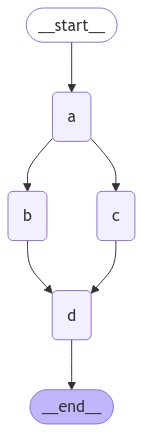

In [3]:
# Reducerを使っておけばエラーが起きないで二つのノードの結果が追加される
import operator
from typing import Annotated

class State(TypedDict):
    state: Annotated[list, operator.add]

builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("私はAです"))
builder.add_node("b", ReturnNodeValue("私はBです"))
builder.add_node("c", ReturnNodeValue("私はCです"))
builder.add_node("d", ReturnNodeValue("私はDです"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "d")
builder.add_edge("c", "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Reducerを指定したのでエラーが起きない
graph.invoke({"state": []})

Adding 私はAです to []
Adding 私はBです to ['私はAです']
Adding 私はCです to ['私はAです']
Adding 私はDです to ['私はAです', '私はBです', '私はCです']


{'state': ['私はAです', '私はBです', '私はCです', '私はDです']}

Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Empty request"}')
Failed to multipart ingest runs: langsmith.utils.LangSmithError: Failed to POST https://api.smith.langchain.com/runs/multipart in LangSmith API. HTTPError('400 Client Error: Bad Request for url: https://api.smith.langchain.com/runs/multipart', '{"detail":"Empty request"}')


## ノードの終了を待つ

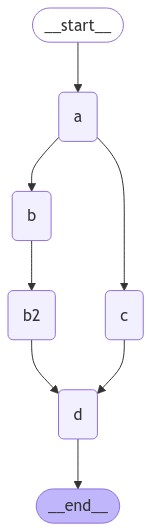

In [5]:
builder = StateGraph(State)

builder.add_node("a", ReturnNodeValue("私はAです"))
builder.add_node("b", ReturnNodeValue("私はBです"))
builder.add_node("b2", ReturnNodeValue("私はB2です"))
builder.add_node("c", ReturnNodeValue("私はCです"))
builder.add_node("d", ReturnNodeValue("私はDです"))

builder.add_edge(START, "a")
builder.add_edge("a", "b")
builder.add_edge("a", "c")
builder.add_edge("b", "b2")
builder.add_edge(["b2", "c"], "d")
builder.add_edge("d", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
# ノードCのあとにノードB2が実行される
graph.invoke({"state": []})

Adding 私はAです to []
Adding 私はBです to ['私はAです']
Adding 私はCです to ['私はAです']
Adding 私はB2です to ['私はAです', '私はBです', '私はCです']
Adding 私はDです to ['私はAです', '私はBです', '私はCです', '私はB2です']


{'state': ['私はAです', '私はBです', '私はCです', '私はB2です', '私はDです']}

## LLMと組み合わせる

In [12]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [33]:
class State(TypedDict):
    question: str
    answer: str

    # 検索結果のコンテキストを追加する
    context: Annotated[list, operator.add]

In [41]:
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults

def search_web(state):
    tavily_search = TavilySearchResults(max_results=3)
    search_docs = tavily_search.invoke(state["question"])

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

def search_wikipedia(state):
    search_docs = WikipediaLoader(query=state["question"], load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

In [48]:
print(search_web({"question": "日本の歴史について教えて"}))

{'context': ['<Document href="https://www.bbc.com/japanese/features-and-analysis-39475888"/>\n私が経験した日本の歴史教育. 2017年12月4日. （編集部注：2013年3月にBBCワールドジャパンのコーポレートサイトに掲載された記事を再掲載してい\n</Document>\n\n---\n\n<Document href="https://nihonshimuseum.com/"/>\n日本の歴史の面白さや魅力を紹介するサイトです。歴史人物の年表や時代ごとの戦い、史跡や諸々のエピソードをはじめ、文化や城、地名や元号などの情報を掲載しています。日本史の学習に役立つ雑学や情報、豆知識も解説中。諸外国との関係も見てみましょう!\n</Document>\n\n---\n\n<Document href="https://ja.wikipedia.org/wiki/日本の歴史"/>\n日本 の歴史における時代区分には様々なものがあり、定説と呼べるものはない。. 原始 ・ 古代 ・ 中世 ・ 近世 ・ 近代 ・ 現代 とする時代区分法が歴史研究では広く受け入れられている。. この場合でも、各時代の画期をいつに置くかは論者によって大きく\n</Document>']}


In [49]:
print(search_wikipedia({"question": "日本の歴史について教えて"}))

{'context': ['<Document source="https://en.wikipedia.org/wiki/Japanese_yen" page=""/>\nThe yen (Japanese: 円, symbol: ¥; code: JPY) is the official currency of Japan. It is the third-most traded currency in the foreign exchange market, after the United States dollar and the euro. It is also widely used as a third reserve currency after the US dollar and the euro.\nThe New Currency Act of 1871 introduced Japan\'s modern currency system, with the yen defined as 1.5 g (0.048 troy ounces) of gold, or 24.26 g (0.780 troy ounces) of silver, and divided decimally into 100 sen or 1,000 rin. The yen replaced the previous Tokugawa coinage as well as the various hansatsu paper currencies issued by feudal han (fiefs). The Bank of Japan was founded in 1882 and given a monopoly on controlling the money supply.\nFollowing World War II, the yen lost much of its pre-war value. To stabilize the Japanese economy, the exchange rate of the yen was fixed at ¥360 per US$ as part of the Bretton Woods system. W

In [50]:
def generate_answer(state):
    context = state["context"]
    question = state["question"]

    answer_template = """以下の質問にコンテキスト情報を使って回答してください。
    質問: {question}
    コンテキスト: {context}
    """
    answer_instructions = answer_template.format(question=question, context=context)

    answer = llm.invoke([SystemMessage(content=answer_instructions)] + [HumanMessage(content="質問に答えてください。")])

    return {"answer": answer}

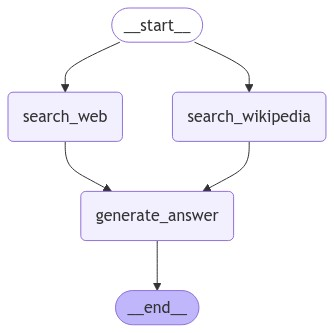

In [51]:
builder = StateGraph(State)

builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_wikipedia")
builder.add_edge(START, "search_web")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [52]:
result = graph.invoke({"question": "日本の歴史について教えて", "context": []})

In [54]:
print(result["answer"].content)

日本の歴史は大きく分けて原始・古代、中世、近世、近代、現代の5つの時代に区分されます。各時代にはさまざまな出来事があり、日本の文化や社会がどのように形成されてきたのかを理解することができます。

- **原始・古代**: 旧石器時代から始まり、弥生時代や古墳時代を経て、奈良時代や平安時代に至ります。この時期には、農業の発展や国家の形成が見られました。

- **中世**: 鎌倉時代や室町時代が含まれ、武士の台頭や戦国時代が特徴的です。この時期には、さまざまな戦いがあり、また文化も栄えました。

- **近世**: 江戸時代がこの時期にあたります。平和な時代が続き、商業や文化が発展しました。

- **近代**: 明治維新を経て、日本は急速に近代化を進めました。この時期には、国際的な関係の変化や戦争も経験しました。

- **現代**: 第二次世界大戦後の復興や経済成長を経て、現在の日本が形成されました。

日本の歴史は非常に多様で、各時代ごとに重要な出来事や人物が存在します。興味がある方は、時代ごとの詳細な出来事や文化について学ぶことをお勧めします。


## サブグラフ

In [35]:
from operator import add
from typing_extensions import TypedDict
from typing import List, Optional, Annotated


class Log(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[int]
    feedback: Optional[str]

/tmp/ipykernel_1082462/2681000154.py:26: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  fa_builder = StateGraph(input=FailureAnalysisState,


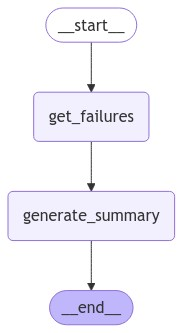

In [36]:
# Sub graphs
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class FailureAnalysisState(TypedDict):
    cleaned_logs: List[Log]
    failures: List[Log]
    fa_summary: str
    processed_logs: List[str]

class FailureAnalysisOutputState(TypedDict):
    fa_summary: str
    processed_logs: List[str]

def get_failures(state):
    # cleaned_logsのリストからgradeが含まれるログを取り出す
    cleaned_logs = state["cleaned_logs"]
    failures = [log for log in cleaned_logs if "grade" in log]
    return {"failures": failures}

def generate_summary(state):
    failures = state["failures"]
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary, "processed_logs": [f"failure-analysis-on-log-{failure['id']}" for failure in failures]}

fa_builder = StateGraph(input=FailureAnalysisState,
                        output=FailureAnalysisOutputState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)

fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)

graph = fa_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

/tmp/ipykernel_1082462/1680117138.py:21: LangGraphDeprecationWarning: Initializing StateGraph without state_schema is deprecated. Please pass in an explicit state_schema instead of just an input and output schema.
  qs_builder = StateGraph(input=QuestionSummarizationState,


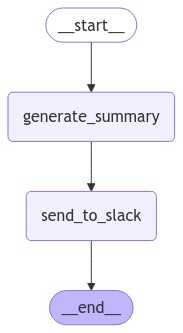

In [26]:
class QuestionSummarizationState(TypedDict):
    cleaned_logs: List[Log]
    qs_summary: str
    report: str
    processed_logs: List[str]

class QuestionSummarizationOutputState(TypedDict):
    report: str
    processed_logs: List[str]

def generate_summary(state):
    cleaned_logs = state["cleaned_logs"]
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary, "processed_logs": [f"summary-on-log{log['id']}" for log in cleaned_logs]}

def send_to_slack(state):
    qs_summary = state["qs_summary"]
    report = "foo bar baz"
    return {"report": report}

qs_builder = StateGraph(input=QuestionSummarizationState,
                        output=QuestionSummarizationOutputState)

qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)

qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", END)

graph = qs_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

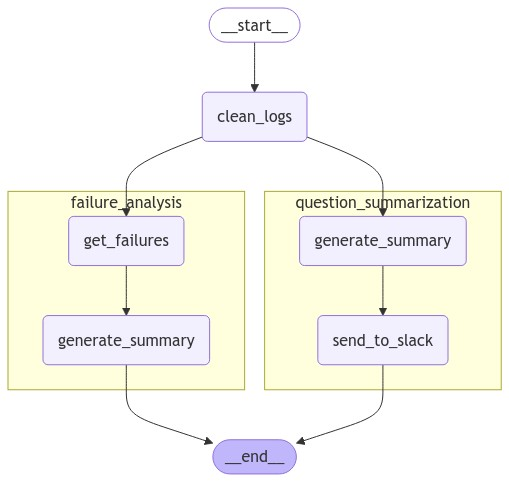

In [37]:
class EntryGraphState(TypedDict):
    raw_logs: List[Log]
    cleaned_logs: List[Log]
    fa_summary: str
    report: str
    processed_logs: Annotated[List[int], add]


def clean_logs(state):
    raw_logs = state["raw_logs"]
    cleaned_logs = raw_logs
    return {"cleaned_logs": cleaned_logs}

entry_builder = StateGraph(EntryGraphState)

entry_builder.add_node("clean_logs", clean_logs)

# サブグラフをノードとして追加
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "clean_logs")
entry_builder.add_edge("clean_logs", "failure_analysis")
entry_builder.add_edge("clean_logs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [38]:
# Dummy logs
question_answer = Log(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Log(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)

raw_logs = [question_answer, question_answer_feedback]
# graph.invoke({"raw_logs": raw_logs})

In [39]:
fa_builder.compile().invoke({"cleaned_logs": raw_logs})

{'fa_summary': 'Poor quality retrieval of Chroma documentation.',
 'processed_logs': ['failure-analysis-on-log-2']}

In [40]:
qs_builder.compile().invoke({"cleaned_logs": raw_logs})

{'report': 'foo bar baz',
 'processed_logs': ['summary-on-log-1', 'summary-on-log-2']}

In [41]:
clean_logs({"raw_logs": raw_logs})

{'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}]}

In [42]:
graph.invoke({"raw_logs": raw_logs})

{'raw_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, but not Chroma specifically'}],
 'cleaned_logs': [{'id': '1',
   'question': 'How can I import ChatOllama?',
   'answer': "To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'"},
  {'id': '2',
   'question': 'How can I use Chroma vector store?',
   'answer': 'To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).',
   'grade': 0,
   'grader': 'Document Relevance Recall',
   'feedback': 'The retrieved documents discuss vector stores in general, 

## Map Reduce

In [44]:
from langchain_openai import ChatOpenAI

subjects_prompt = """この全体的なトピックに関連する3つのサブトピックのリストを生成してください: {topic}"""
joke_prompt = """{subject}に関するジョークを生成してください"""
best_joke_prompt = """{topic}に関する以下のジョークの中から最高のものを選んでください。最初のジョークをID 0として、最高のジョークのIDを返してください。

ジョーク一覧:
{jokes}"""

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

In [46]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel

# LLMの出力フォーマット用のクラス
class Subjects(BaseModel):
    subjects: list[str]

class BestJoke(BaseModel):
    id: int

# LangGraphの状態を定義
class OverallState(TypedDict):
    topic: str
    subjects: list
    jokes: Annotated[list, operator.add]
    best_selected_joke: str

In [48]:
# topicに関するサブトピックを生成
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}

In [ ]:
from langgraph.constants import Send

# Mapにあたる処理
# Mapもconditional edgeとして実装できる
def continue_to_jokes(state: OverallState):
    # ジョークを生成するノードを複数並列に呼び出せる
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]

In [52]:
class JokeState(TypedDict):
    subject: str

class Joke(BaseModel):
    joke: str

def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}

In [53]:
# Reduce処理
def best_joke(state: OverallState):
    jokes = "\n\n".join(state["jokes"])
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}

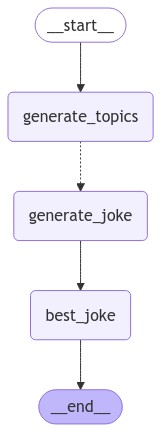

In [56]:
from IPython.display import Image, display
from langgraph.graph import END, StateGraph, START

graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)

graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)

app = graph.compile()

# generate_jokeはMap処理によって複数のノードが並列に実行される
display(Image(app.get_graph().draw_mermaid_png()))

In [60]:
for s in app.stream({"topic": "動物の種類"}):
    print(s)

{'generate_topics': {'subjects': ['哺乳類', '鳥類', '爬虫類']}}
{'generate_joke': {'jokes': ['なぜ哺乳類はいつもパーティーを開くのが好きなの？\n\nだって、彼らは「ミルク」を持っているから！']}}
{'generate_joke': {'jokes': ['なぜ鳥はコンピュータを使わないの？\n\nだって、いつもフラップしてしまうから！']}}
{'generate_joke': {'jokes': ['なぜ爬虫類はパーティーに行くのが好きなの？\n\nだって、彼らはいつも「リザード」しているから！']}}
{'best_joke': {'best_selected_joke': 'なぜ哺乳類はいつもパーティーを開くのが好きなの？\n\nだって、彼らは「ミルク」を持っているから！'}}
